In [1]:
import os 
figure_folder = 'figures-v2'
os.makedirs(figure_folder, exist_ok=True)

n_ms_per_s= 1000
n_total_trial= 100

curation = {
    'M15_2': {
        'CA1': (4.5, [1, 16, 17, 18, 25, 26, 27, 35, 42, 53]),
        # Noisy 'M1': [], 
    }, 
    'M15_3': {
        'M1': (5.5, [17, 18]), 
        # Noisy 'CA1': (), 
    }, 
    'M15_5': {
        'CA1': (3.5, [8, 9, 10, 15, 21, 62]),
        'M1': (3.5, [28, 29, 31, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44]),
    }, 
    'M15_7': {
        'CA1': (4.5, [11, 12, 13, 22, 23]),
        'M1': (3.5, [23, 24, 25, 29, 30, 32, 37, 41, 42, 44, 45, 46, 47, 51, 52, 53, 56, 57, 58]),
    }, 
    'M16_1': {
        'CA1': (5.5, [1, 2, 4, 5, 8, 19, 28, 29, 34, 36, 38, 39, 41, 42, 43, 67, 69, 70]),
        # Noisy 'M1': (), 
    },
}

import os
import shutil 

for subject, subject_curation in curation.items():
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/curated/{region}'
        os.makedirs(output_folder, exist_ok=True)

        for unit_id in curated_units:
            shutil.copy2(f'data/processed/{subject}/{region}/curations-{threshold}/{unit_id}.png', f'{output_folder}/{subject}-{threshold}-{unit_id}.png')

# Reaction Time

In [ ]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator


session_palette = {
    session_index + 1: color for session_index, color in enumerate(['#D1D9EC', '#a2b1d8', '#8597c6', '#697fb7', '#ffbcbb', '#ffb5b4', '#ffaeac', '#ffa6a5', '#e44e4b', '#d93f3c', '#cc3330', '#b03533', '#ddde29', '#bcbd21'])
}

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

reaction_times = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
        state_ids = np.where(events['state'] == 'state')[0]
        if len(state_ids) > 0:
            events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            events['x'] = pd.to_numeric(events['x'])
            events['y'] = pd.to_numeric(events['y'])
            events['time'] = pd.to_numeric(events['time'])
            events['state'] = pd.to_numeric(events['state'])
            events['trial'] = pd.to_numeric(events['trial'])
            events['s_trial'] = pd.to_numeric(events['s_trial'])
            events['f_trial'] = pd.to_numeric(events['f_trial'])

        events['x'] = analog_to_digital(events['x'])
        events['y'] = analog_to_digital(events['y'])
        events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
        events['time'] = events['time'] - events['time'][0]
        events['time'] = events['time'] / n_ms_per_s 

        for trial in range(n_total_trial):
            trial_indices = np.where(events['trial'] == trial)[0]
            if any(events['state'][trial_indices] == 1):
                trial_reaction_index = np.where((events['trial'] == trial) & (events['state'] == 1))[0][0]
                reaction_times.append({
                    'subject': subject,
                    'session': session_index+1,
                    'reaction': events['time'][trial_reaction_index] - events['time'][trial_indices.min()],
                })
        
reaction_times = pd.DataFrame(reaction_times)

In [ ]:
fig = plt.figure(figsize=(10, 15))
for session in range(1, reaction_times['session'].max()+1):
    ax = plt.subplot(len(reaction_times['session'].unique())+1, 1, session)
    sns.kdeplot(data=reaction_times[reaction_times['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
    ax.set_ylim(0, 0.28)
    ax.set_xlim(-3, 12)
    ax.set_ylabel(session)
    ax.set_yticks([])
    ax.set_axis_off()
ax.set_axis_on()
fig.suptitle(f'Reaction time distribution')
plt.savefig(f'{figure_folder}/reaction_density.pdf')
plt.show()
plt.close()

In [ ]:
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    stats = reaction_times[reaction_times['subject']==subject]
    fig = plt.figure(figsize=(10, 15))
    for session in range(1, stats['session'].max()+1):
        ax = plt.subplot(len(stats['session'].unique())+1, 1, session)
        sns.kdeplot(data=stats[stats['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
        ax.set_ylim(0, 0.15)
        ax.set_xlim(-3, 13)
        ax.set_ylabel(session)
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_axis_off()
    ax.set_axis_on()
    fig.suptitle(f'{subject} - Reaction time distribution')
    plt.savefig(f'{figure_folder}/{subject}_reaction_density.pdf')
    plt.show()
    plt.close()

# Success Rate

In [ ]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

In [ ]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

In [ ]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()

# Unit Raster Plots

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se 

from tqdm.auto import tqdm

s_before_cue, s_after_cue = 5, 5

for subject, subject_curation in curation.items():
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/raster-{s_before_cue}-{s_after_cue}/{region}'
        os.makedirs(output_folder, exist_ok=True)

        session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
        n_segment = len(session_info)

        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)
        
        for unit_id in tqdm(curated_units):
            spike_trains, s_spike_trains, f_spike_trains = [], [], []
            for segment_index in range(n_segment):
                segment_spike_trains, segment_s_spike_trains, segment_f_spike_trains = [], [], []
                segment_info = session_info[session_info['segment_index']==segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                s_trials, f_trials = [], []
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial

                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    t_start = trial_start - s_before_cue * sorting.sampling_frequency
                    t_end = min(trial_end, trial_start + s_after_cue * sorting.sampling_frequency)

                    trial_spike_train = unit_spike_train[(unit_spike_train >= t_start) & (unit_spike_train < t_end)] - trial_start
                    trial_spike_train = trial_spike_train / sorting.sampling_frequency 
                    segment_spike_trains.append(trial_spike_train)

                    if trial in s_trials:
                        segment_s_spike_trains.append(trial_spike_train)
                    elif trial in f_trials:
                        segment_f_spike_trains.append(trial_spike_train)
                    else:
                        raise Exception
                spike_trains.append(segment_spike_trains)
                s_spike_trains.append(segment_s_spike_trains)
                f_spike_trains.append(segment_f_spike_trains)
                
                all_spike_trains = []
                for segment_spike_trains in spike_trains:
                    all_spike_trains.extend(segment_spike_trains)

                all_s_spike_trains = []
                for segment_s_spike_trains in s_spike_trains:
                    all_s_spike_trains.extend(segment_s_spike_trains)

                all_f_spike_trains = []
                for segment_f_spike_trains in f_spike_trains:
                    all_f_spike_trains.extend(segment_f_spike_trains)

                spike_train_counts = [len(segment_spike_trains) for segment_spike_trains in spike_trains]
                s_spike_train_counts = [len(segment_s_spike_trains) for segment_s_spike_trains in s_spike_trains]
                f_spike_train_counts = [len(segment_f_spike_trains) for segment_f_spike_trains in f_spike_trains]

                fig = plt.figure(figsize=(10, 6))
                fig.suptitle(f'{subject} - {region} - threshold {threshold} - unit {unit_id}')
                ax = plt.subplot(1, 3, 1)
                ax.eventplot(all_spike_trains)
                for segment_index, y in enumerate(np.cumsum(spike_train_counts)):
                    ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
                    ax.text(s_after_cue+0.2, y, f'{segment_index+1} ({len(spike_trains[segment_index])})')
                ax.set_ylabel('Trials')
                ax.set_title('All trials')

                ax = plt.subplot(1, 3, 2)
                ax.eventplot(all_s_spike_trains)
                for segment_index, y in enumerate(np.cumsum(s_spike_train_counts)):
                    ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
                    ax.text(s_after_cue+0.2, y, f'{segment_index+1} ({len(s_spike_trains[segment_index])})')
                ax.set_ylabel('Trials')
                ax.set_title('Successful trials')

                ax = plt.subplot(1, 3, 3)
                ax.eventplot(all_f_spike_trains)
                for segment_index, y in enumerate(np.cumsum(f_spike_train_counts)):
                    ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
                    ax.text(s_after_cue+0.2, y, f'{segment_index+1} ({len(f_spike_trains[segment_index])})')
                ax.set_ylabel('Trials')
                ax.set_title('Failed trials')

                plt.tight_layout()
                plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}.png')
                # plt.show()
                plt.close()

# Overall Heatmap

In [22]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se 

from tqdm.auto import tqdm

s_before_cue, s_after_cue = 5, 5

spike_trains, s_spike_trains, f_spike_trains = {}, {}, {}
for region in ['CA1', 'M1']:
    spike_trains[region], s_spike_trains[region], f_spike_trains[region] = {}, {}, {}
    for subject, subject_curation in curation.items():
        if region not in subject_curation: continue
        threshold, curated_units = subject_curation[region]

        session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
        n_segment = len(session_info)

        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)
        
        for segment_index in (pbar := tqdm(range(n_segment))):
            pbar.set_description(f'{subject} - {region} - {len(curated_units)} units')

            segment_spike_trains = spike_trains[region].get(segment_index, {})
            segment_s_spike_trains = s_spike_trains[region].get(segment_index, {})
            segment_f_spike_trains = f_spike_trains[region].get(segment_index, {})

            segment_info = session_info[session_info['segment_index']==segment_index]

            controller_date = segment_info['segment_path'].item().split('_')[-2]
            controller_date = controller_date[2:] + controller_date[:2]
            controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
            events = pd.read_csv(controller_file)
            # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
            state_ids = np.where(events['state'] == 'state')[0]
            if len(state_ids) > 0:
                events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            s_trials, f_trials = [], []
            for trial in range(n_total_trial):
                trial_indices = np.where(events['trial'] == trial)[0]
                if any(events['state'][trial_indices] == 1):
                    s_trials.append(trial)
                else:
                    f_trials.append(trial)
            assert len(s_trials) + len(f_trials) == n_total_trial

            trial_starts = eval(segment_info['trial_starts'].item())
            trial_ends = eval(segment_info['trial_ends'].item())

            for unit_id in curated_units:
                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_spike_trains[f'{subject}-{unit_id}'] = []
                segment_s_spike_trains[f'{subject}-{unit_id}'] = []
                segment_f_spike_trains[f'{subject}-{unit_id}'] = []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    t_start = trial_start - s_before_cue * sorting.sampling_frequency
                    t_end = min(trial_end, trial_start + s_after_cue * sorting.sampling_frequency)

                    trial_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)
                    trial_spike_train = trial_spike_train[(trial_spike_train >= t_start) & (trial_spike_train < t_end)] - trial_start
                    trial_spike_train = trial_spike_train / sorting.sampling_frequency 
                    
                    segment_spike_trains[f'{subject}-{unit_id}'].append(trial_spike_train)

                    if trial in s_trials:
                        segment_s_spike_trains[f'{subject}-{unit_id}'].append(trial_spike_train)
                    elif trial in f_trials:
                        segment_f_spike_trains[f'{subject}-{unit_id}'].append(trial_spike_train)
                    else:
                        raise Exception
            spike_trains[region][segment_index] = segment_spike_trains
            s_spike_trains[region][segment_index] = segment_s_spike_trains
            f_spike_trains[region][segment_index] = segment_f_spike_trains
    break

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
# for region in ['CA1', 'M1']:
#     for segment in range(n_segment):
#         segment_spike_trains = spike_trains[region][segment]

#         for 
spike_trains['CA1'][0].keys()

dict_keys(['M15_2-1', 'M15_2-16', 'M15_2-17', 'M15_2-18', 'M15_2-25', 'M15_2-26', 'M15_2-27', 'M15_2-35', 'M15_2-42', 'M15_2-53', 'M15_5-8', 'M15_5-9', 'M15_5-10', 'M15_5-15', 'M15_5-21', 'M15_5-62', 'M15_7-11', 'M15_7-12', 'M15_7-13', 'M15_7-22', 'M15_7-23', 'M16_1-1', 'M16_1-2', 'M16_1-4', 'M16_1-5', 'M16_1-8', 'M16_1-19', 'M16_1-28', 'M16_1-29', 'M16_1-34', 'M16_1-36', 'M16_1-38', 'M16_1-39', 'M16_1-41', 'M16_1-42', 'M16_1-43', 'M16_1-67', 'M16_1-69', 'M16_1-70'])

In [52]:
np.array(unit_bins)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

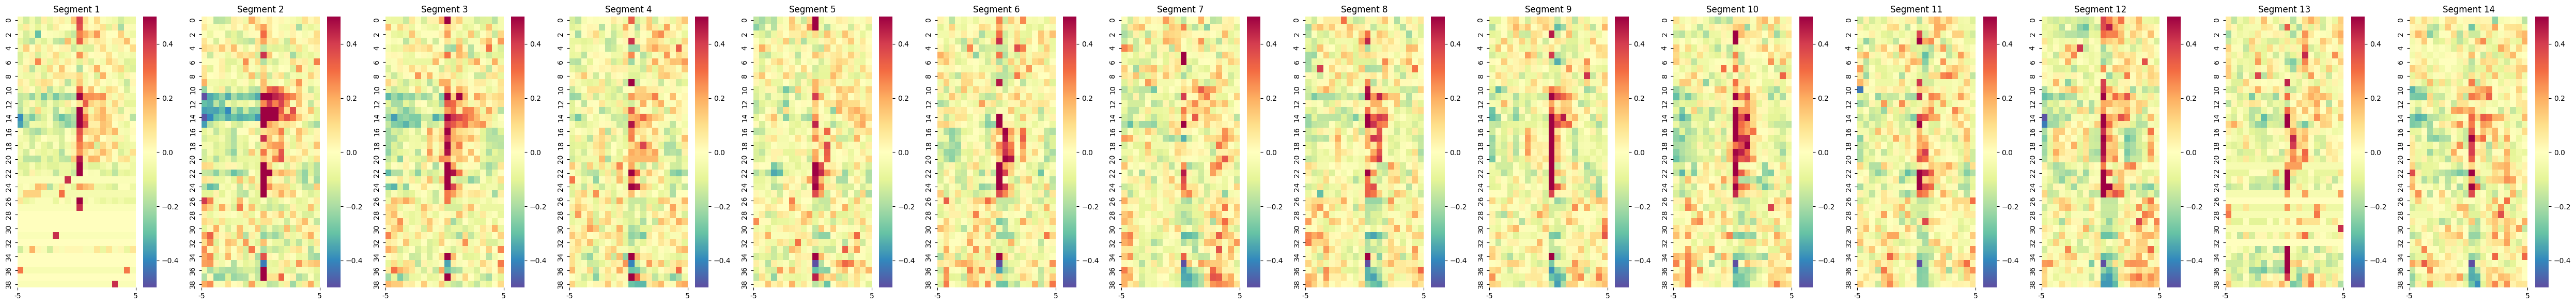

In [73]:
import seaborn as sns
bin_size = 500

for region, region_spike_trains in spike_trains.items():
    spike_bins = []
    for segment_index in range(n_segment):
        segment_spike_bins = []
        for unit_id, unit_spike_trains in region_spike_trains[segment_index].items():
            unit_bins = []
            for trial_spike_train in unit_spike_trains:
                unit_bins.append(np.histogram(trial_spike_train, bins=np.arange(-s_before_cue, s_after_cue+1e-6, bin_size/n_ms_per_s))[0])
            unit_bins = np.array(unit_bins)
            unit_bins = (unit_bins - unit_bins.mean()) / (unit_bins.std() + 1e-6)
            segment_spike_bins.append(unit_bins.mean(0))
        segment_spike_bins = np.array(segment_spike_bins)
        spike_bins.append(segment_spike_bins)

    fig = plt.figure(figsize=(50, 6))
    for segment_index in range(n_segment):
        ax = plt.subplot(1, n_segment, segment_index+1)
        sns.heatmap(spike_bins[segment_index], ax=ax, cmap=plt.cm.Spectral_r, vmin=-0.5, vmax=0.5)
        ax.set_title(f'Segment {segment_index+1}')
        ax.set_xticks([0, spike_bins[segment_index].shape[1]], [-s_before_cue, s_after_cue])
    plt.tight_layout()
    plt.show()